# Denna notebook är för modelleringen

## Inledning

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [12]:
X = mnist['data']
y = mnist['target'].astype(np.uint8)

print(X.shape)
print(y.shape)
print(X.dtype)

X = X.astype('float32')
y = y.astype('float32')

print(X.dtype)

(70000, 784)
(70000,)
int64
float32


In [13]:
# Delar upp datan i train, val och test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

## EDA

Sanna värdet för bilden 0


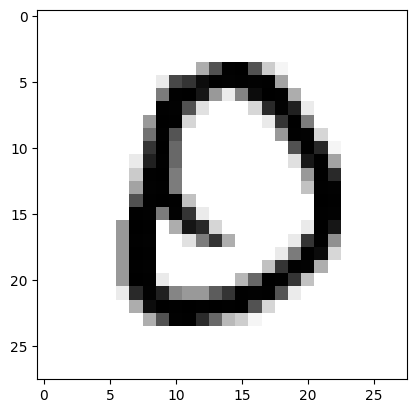

In [14]:
some_digit = X_train[5]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
print('Sanna värdet för bilden', y_train[5])

Kontrollerar hur balansen ser ut mellan sifforna. Ifall någon har många färre eller fler än de andra.

Jag ser att 1:orna har 400-500st mer än snittet och 5.or har ca 400 färre. 

In [18]:
pd.Series(y_train).value_counts().sort_index()

0    4136
1    4676
2    4235
3    4292
4    4146
5    3758
6    4101
7    4363
8    4107
9    4186
Name: count, dtype: int64

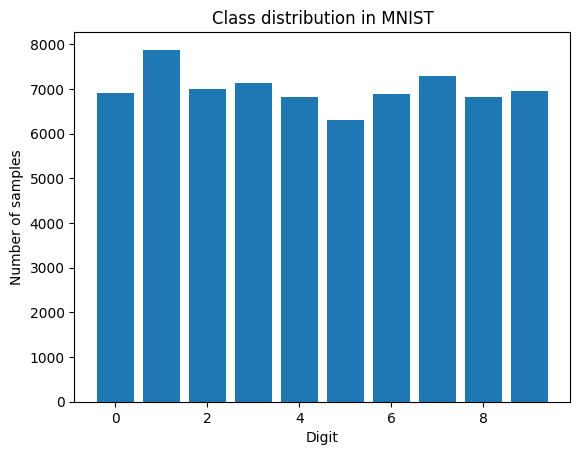

In [20]:
classes, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts)
plt.xlabel("Digit")
plt.ylabel("Number of samples")
plt.title("Class distribution in MNIST")
plt.show()

Nu ska jag kolla på hur variansen inom de olika sifforna ser ut för att veta vad jag har att arbeta med. 

In [ ]:
#En funktion som jag fått hjälp att göra (av ChatGPT eftersom jag inte hade koll på EDA för bild-data) för att enklare kolla alla siffor
def show_examples(X, y, digit, n=16, image_shape=(28, 28)):
    idx = np.where(y == digit)[0][:n]
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))

    for ax, i in zip(axes.ravel(), idx):
        img = X[i].reshape(image_shape) if X[i].ndim == 1 else X[i]
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.suptitle(f"Examples of digit {digit}")
    plt.tight_layout()
    plt.show()

### Visuell check av variansen inom klasserna

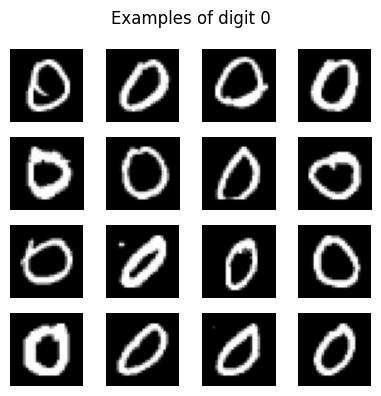

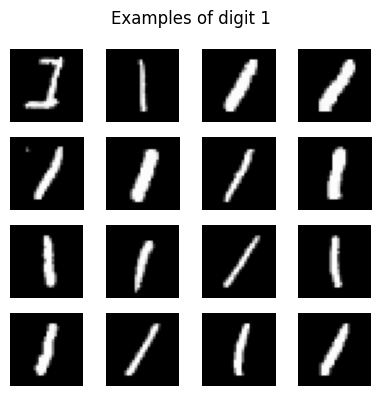

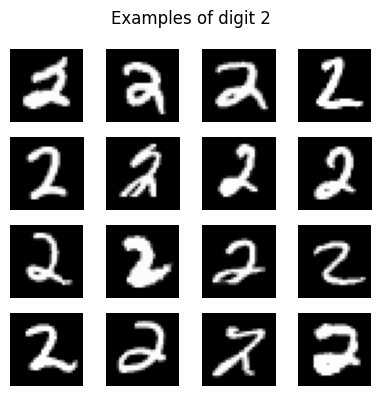

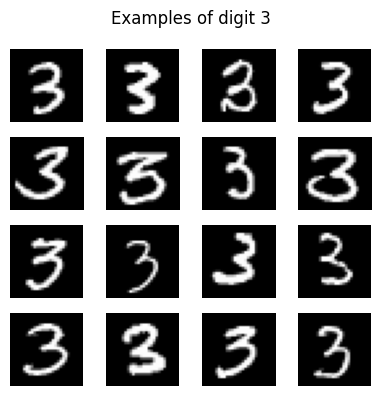

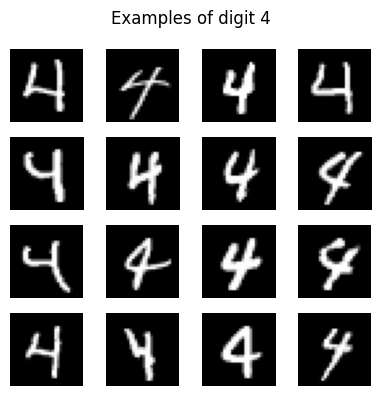

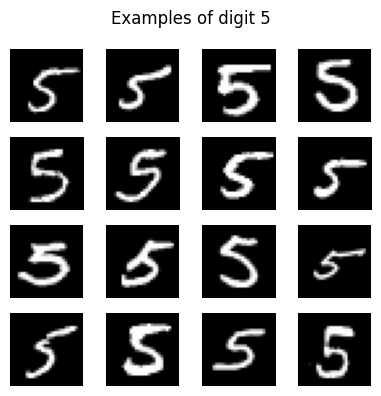

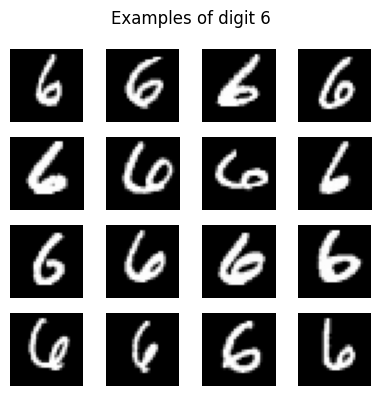

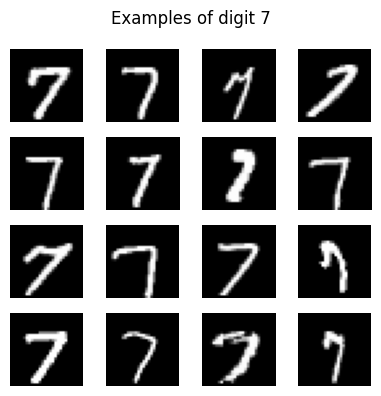

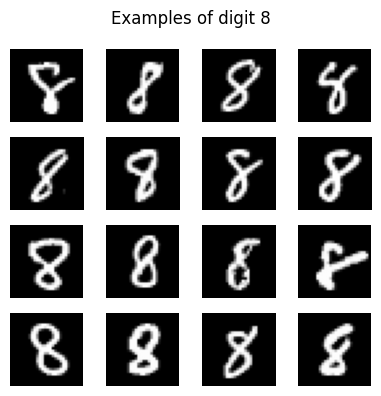

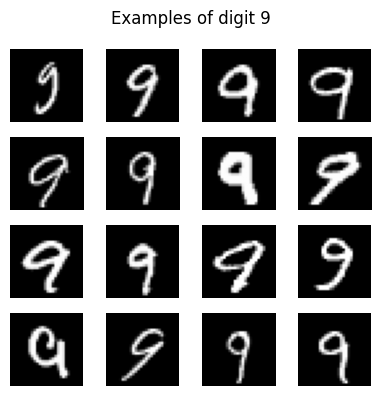

In [27]:
show_examples(X_train, y_train, digit=0)
show_examples(X_train, y_train, digit=1)
show_examples(X_train, y_train, digit=2)
show_examples(X_train, y_train, digit=3)
show_examples(X_train, y_train, digit=4)
show_examples(X_train, y_train, digit=5)
show_examples(X_train, y_train, digit=6)
show_examples(X_train, y_train, digit=7)
show_examples(X_train, y_train, digit=8)
show_examples(X_train, y_train, digit=9)


## Modellering

Börjar med att importera det jag behöver för mina modellering

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA
import time

Gör ett mindre subset som jag kommer att använda för att ta fram hyperparametrana för att det ska gå snabbare och eftersom detta datasetet är så pass homogent så ska det gå bra att skala upp utan att hyperparametrarna blir dåliga. 

Jag gör två subset ett på 15k som jag anväder för de grova hyperparameterkollen och jämförelsen med de olika modellerna och ett sett på 35k för fin justeringen på den modellen jag använder. 

In [59]:
# Subset med 10k och 32k rader: 
X_32k, X_10k, y_32k, y_10k = train_test_split(X_train, y_train, test_size=10000, stratify=y_train, random_state=42)


In [95]:
# modellerna jag kommer börja testa
logref_clf = LogisticRegression(max_iter=1000)
et_clf = ExtraTreesClassifier(n_jobs=1) #Sätter n_jobs till 1 eftersom GridSearchCV kommer ha -1 och detta motverkar nestlad parallellism vilket då blir långsammare
lin_svc_clf = LinearSVC(max_iter=5000, dual=False)
kNN_clf = KNeighborsClassifier()
svc_clf = SVC(kernel='rbf')


# Lista med modeller, används i träningsloopen
models = [logref_clf, et_clf, svc_clf]

# Vilka hyperparametrar för ExtraTree som ska testas i RandomizedSearchCV
et_param_dist = {
    "n_estimators": randint(200, 550),
    "max_depth": [15, 20, 25],
    "min_samples_leaf": randint(1, 6),
    "min_samples_split": randint(2, 21),
    "max_features": ["sqrt", 0.5],
    "min_impurity_decrease": uniform(0.0, 1e-4)
}

svc_param_dist = {
    "classifier__C": [0.001, 0.01, 0.05]
}

kNN_param_dist = {
    "classifier__n_neighbors": [3, 5, 6, 7],
    "classifier__weights": ['uniform', 'distance'],
    "classifier__metric": ['euclidean']
}

kNN_pca_param_dist = {
    "pca__n_components": [40, 45, 50, 55, 60, 65],
    "classifier__n_neighbors": [2, 3, 4, 5, 6],
    "classifier__weights": ['uniform', 'distance'],
    "classifier__metric": ['euclidean']
}

svc_pca_param_dist = {
    "pca__n_components": [0.90, 0.92, 0.93, 0.94, 0.95, 0.97],
    "classifier__C": [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10]
}

svc_rbf_pca_param_dist = {
    "pca__n_components": [0.90, 0.95, 0.97, 0.99, 30, 50, 80, 120],
    "classifier__C": [0.1, 0.3, 1, 3, 10, 30, 100],
    "classifier__gamma": ["scale", "auto", 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# För att spara resultaten från träningsloopen
best_models = {}
best_scores = {}
best_params = {}
val_scores = {}
fit_time_sec = {}

Jag gjorde först kontrollen av modellerna med en for loop med if-else logik vilket fungerade bra när jag bara hade tre modeller som jag ville testa. Men jag är nyfiken så nu är jag uppe i 4 modeller (två av dom jag började med) och hade velat testa med och utan PCA också. Och när det växte så kände jag att det blev för svårt att hålla koll på att allt blev med parametrar och väldigt oövergripligt. Så min if-else fungerar inte längre pga överskådligheten (den fungerar ju att köra). 

Så min lösning på detta är att göra en lista med alla experiment jag vill genomföra, skapaa en funktion som jag kan använda för att träna med de transformationer de behöver och prediktera mina modeller och sprara resutlatet i mina dictonarys. 

Denna funktion använder jag sen ska använda i for-loopen istället.

In [83]:
experiment = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_dist': None,
        'n_iter': None
    },
    {
        'name': 'ExtraTreesClassifier',
        'estimator': et_clf,
        'param_dist': et_param_dist,
        'n_iter': 50
    },
    {
        'name': 'LinearSVC_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', lin_svc_clf)
        ]),
        'param_dist': svc_param_dist,
        'n_iter': 10
    },
    {
        'name': 'KNeighborsClassifier_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', kNN_clf)
        ]),
        'param_dist': kNN_param_dist,
        'n_iter': 30
    },
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_dist': kNN_pca_param_dist,
        'n_iter': 30
    },
    {
        'name': 'LinearSVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', lin_svc_clf)
        ]),
        'param_dist': svc_pca_param_dist,
        'n_iter': 10
    },
    {
        'name': 'rbf_SVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_dist': svc_rbf_pca_param_dist,
        'n_iter': 30
    }
]

In [62]:
def fit_and_eval(exp, X_fit, y_fit, X_val, y_val, cv, n_jobs=12, random_state=42, verbose=1):
    # en tidtagning för att se hur lång varje träning tar
    start_time = time.perf_counter()

    # tar ut variablerna från min expriment dict.
    name = exp['name']
    estimator = exp['estimator']
    param_dist = exp['param_dist']
    n_iter = exp['n_iter']

    # För simpla modeller som inte ska tränas med RandomizedSearchCV
    if param_dist is None:
        estimator.fit(X_fit, y_fit)
        y_pred = estimator.predict(X_val)
        val_score = accuracy_score(y_val, y_pred)
        elapsed = time.perf_counter() - start_time

        return {
            "name": name,
            "best_estimator": estimator,
            "best_params": None,
            "best_cv_score": None,
            "val_score": val_score,
            "fit_time_sec": elapsed
        }
    
    # Förbereder RandomizedSearch med dess parametrar
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        refit=True
    )

    search.fit(X_fit, y_fit)
    y_pred = search.predict(X_val)
    val_score = accuracy_score(y_val, y_pred)
    elapsed = time.perf_counter() - start_time

    return {
        "name": name,
        "best_estimator": search.best_estimator_,
        "best_params": search.best_params_,
        "best_cv_score": search.best_score_,
        "val_score": val_score,
        "fit_time_sec": elapsed
    }

For-loopen:

In [71]:
for exp in experiment:
    result = fit_and_eval(
        exp,
        X_fit=X_10k,
        y_fit=y_10k,
        X_val=X_val,
        y_val=y_val,
        cv=cv,
        n_jobs=12,
        random_state=42,
        verbose=1
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]
    fit_time_sec[name] = result["fit_time_sec"]

    print(f"\n ----- {name} -----") #adderade lite utsmyckning då det var svårt att se var den ena modellen började och den andra slutade
    print(f"Val_accuracy: {val_scores[name]:.4f}")
    if best_scores[name] is not None:
        print(f"Best_cv_score:, {best_scores[name]:.4f}")
        print('Best_params:', best_params[name])
    print(f'Fit_time: {fit_time_sec[name]:.4f} sec = {(fit_time_sec[name])/60:.4f} min' )



 ----- LogisticRegression_scaled -----
Val_accuracy: 0.8807
Fit_time: 1.3305 sec = 0.0222 min
Fitting 3 folds for each of 50 candidates, totalling 150 fits

 ----- ExtraTreesClassifier -----
Val_accuracy: 0.9497
Best_cv_score:, 0.9503
Best_params: {'max_depth': 20, 'max_features': 'sqrt', 'min_impurity_decrease': np.float64(8.16431873219384e-05), 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 323}
Fit_time: 1116.7601 sec = 18.6127 min
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\tiinu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



 ----- LinearSVC_scaled -----
Val_accuracy: 0.8913
Best_cv_score:, 0.8832
Best_params: {'classifier__C': 0.01}
Fit_time: 225.0972 sec = 3.7516 min
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\tiinu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 8 is smaller than n_iter=30. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



 ----- KNeighborsClassifier_scaled -----
Val_accuracy: 0.9194
Best_cv_score:, 0.9132
Best_params: {'classifier__weights': 'distance', 'classifier__n_neighbors': 6, 'classifier__metric': 'euclidean'}
Fit_time: 6.2317 sec = 0.1039 min
Fitting 3 folds for each of 30 candidates, totalling 90 fits

 ----- KNeighborsClassifier_scaled_pca -----
Val_accuracy: 0.9402
Best_cv_score:, 0.9343
Best_params: {'pca__n_components': 60, 'classifier__weights': 'distance', 'classifier__n_neighbors': 4, 'classifier__metric': 'euclidean'}
Fit_time: 8.1723 sec = 0.1362 min
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 ----- LinearSVC_scaled_pca -----
Val_accuracy: 0.9006
Best_cv_score:, 0.8951
Best_params: {'pca__n_components': 0.92, 'classifier__C': 0.03}
Fit_time: 917.0575 sec = 15.2843 min
Fitting 3 folds for each of 30 candidates, totalling 90 fits

 ----- rbf_SVC_scaled_pca -----
Val_accuracy: 0.9489
Best_cv_score:, 0.9472
Best_params: {'pca__n_components': 50, 'classifier__gamma': 'sc

Går vidare med RBF-SVC och KNeigbors med pca. Hade kunnat gå vidare med Extra Tree också men den tar så lång tid så jag hoppar den. 

In [77]:
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()

log_reg: 	 0.86
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1424
         1.0       0.95      0.95      0.95      1601
         2.0       0.82      0.83      0.82      1375
         3.0       0.82      0.84      0.83      1416
         4.0       0.88      0.88      0.88      1383
         5.0       0.79      0.76      0.77      1282
         6.0       0.89      0.90      0.89      1379
         7.0       0.89      0.88      0.89      1427
         8.0       0.79      0.77      0.78      1361
         9.0       0.83      0.83      0.83      1352

    accuracy                           0.86     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.86      0.86      0.86     14000



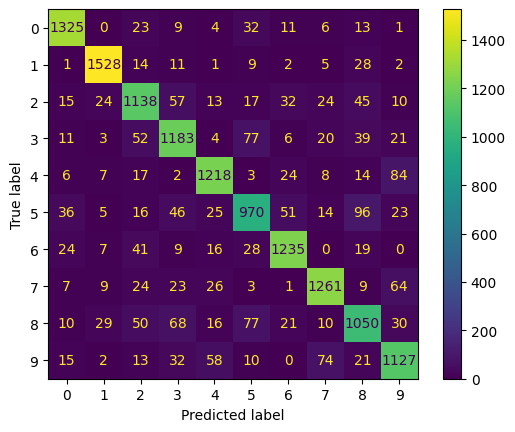

In [ ]:
kNN_clf_best = best_models['KNeighborsClassifier_scaled_pca']
rbf_svc_clf_best = best_models['rbf_SVC_scaled_pca']

logref_clf.fit(X_10k, y_10k)
y_pred_logreg = logref_clf.predict(X_val)

kNN_clf_best.fit(X_10k, y_10k)
y_pred_knn = kNN_clf_best.predict(X_val)

rbf_svc_clf_best.fit(X_10k, y_10k)
y_pred_svc = rbf_svc_clf_best.predict(X_val)

print(f'log_reg: \t {accuracy_score(y_val, y_pred_logreg):.2f}')
print(classification_report(y_val, y_pred_logreg))
display_confusion_matrix(y_val, y_pred_logreg)


 kNN: 	 0.94
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1424
         1.0       0.97      0.99      0.98      1601
         2.0       0.95      0.92      0.94      1375
         3.0       0.94      0.92      0.93      1416
         4.0       0.94      0.93      0.94      1383
         5.0       0.93      0.92      0.92      1282
         6.0       0.95      0.97      0.96      1379
         7.0       0.94      0.93      0.94      1427
         8.0       0.92      0.93      0.92      1361
         9.0       0.90      0.90      0.90      1352

    accuracy                           0.94     14000
   macro avg       0.94      0.94      0.94     14000
weighted avg       0.94      0.94      0.94     14000



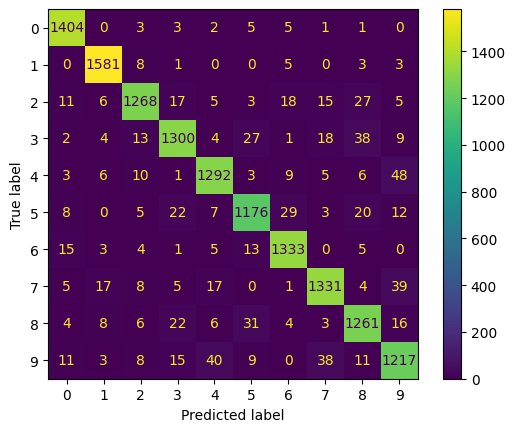

In [80]:
print(f'\n kNN: \t {accuracy_score(y_val, y_pred_knn):.2f}')
print(classification_report(y_val, y_pred_knn))
display_confusion_matrix(y_val, y_pred_knn)


 SVC: 	 0.95
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1424
         1.0       0.97      0.98      0.98      1601
         2.0       0.94      0.94      0.94      1375
         3.0       0.95      0.94      0.94      1416
         4.0       0.94      0.96      0.95      1383
         5.0       0.95      0.93      0.94      1282
         6.0       0.96      0.96      0.96      1379
         7.0       0.93      0.94      0.94      1427
         8.0       0.94      0.94      0.94      1361
         9.0       0.94      0.90      0.92      1352

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



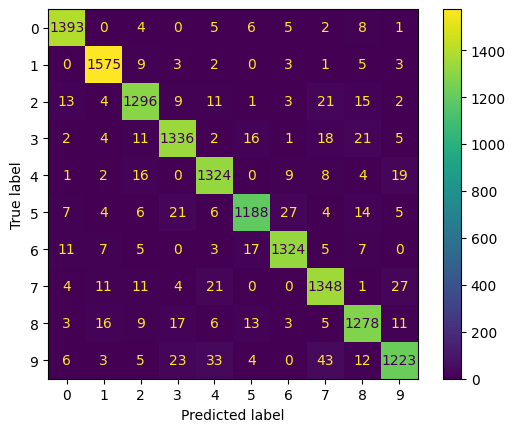

In [81]:
print(f'\n SVC: \t {accuracy_score(y_val, y_pred_svc):.2f}')
print(classification_report(y_val, y_pred_svc))
display_confusion_matrix(y_val, y_pred_svc)

Efter att ha kollat hur bra modellerna är så ska jag gå vidare och fortsätta kolla hyperparametrarna

In [96]:
#Gör en ny funktion för hyperparameter test, denna gången med GridSearchCV istället för RandomizedCV
def hyperparameter_gridsearch_test(exp, X_test, y_test, X_val, y_val, cv, n_jobs=12, verbose=1):
    """Testar modellen (exp) med hjälp av GridSearchCV för att kartlägga de bästa hyperparametrarna"""
    
    start_time = time.perf_counter()

    # tar ut variablerna från min expriment dict.
    name = exp['name']
    estimator = exp['estimator']
    param_grid = exp['param_grid']

    # För simpla modeller som inte ska tränas med RandomizedSearchCV
    if param_grid is None:
        estimator.fit(X_test, y_test)
        y_pred = estimator.predict(X_val)
        val_score = accuracy_score(y_val, y_pred)
        elapsed_time = time.perf_counter() - start_time

        return {
            "name": name,
            "best_estimator": estimator,
            "best_params": None,
            "best_cv_score": None,
            "val_score": val_score,
            "fit_time_sec": elapsed_time
        }

    #Sätter upp GridsearchCV
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=n_jobs,
        verbose=verbose
    )

    grid.fit(X_test, y_test)
    y_pred = grid.predict(X_val)
    val_score = accuracy_score(y_pred, y_val)
    elapsed_time = time.perf_counter() - start_time

    return {
        "name": name,
        "best_estimator": grid.best_estimator_,
        "best_params": grid.best_params_,
        "best_cv_score": grid.best_score_,
        "val_score": val_score,
        "fit_time_sec": elapsed_time
    }


### Första testet med Gridsearch
Väljer vilka hyperparametrar jag vill testa

In [110]:
kNN_pca_param_grid = {
    "pca__n_components": [40, 50, 55, 60, 65, 70],
    "classifier__n_neighbors": [2, 5, 10, 15],
    "classifier__weights": ['uniform', 'distance'],
    "classifier__metric": ['euclidean']
}

svc_rbf_pca_param_grid = {
    "pca__n_components": [50],
    "classifier__C": [0.3, 1, 3, 10],
    "classifier__gamma": ["scale", 3e-4, 1e-3, 3e-3, 1e-2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Sätter upp de modeller jag vill testa och dess pipelines. Jag inkluderar även en Logreg för att ha som baseline. 

In [ ]:
experiment_1 = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_grid': None
    },    
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_grid': kNN_pca_param_grid
    },
    {
        'name': 'rbf_SVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_grid': svc_rbf_pca_param_grid
    }
]

best_models = {}
best_scores = {}
best_params = {}
val_scores = {}
fit_time_sec = {}

Sedan gör jag en for-loop för att testa mina modeller och dess hyperparametrar. Jag gillar att göra det i for-loop för då får jag med alla modeller i en körning och så kan jag koncentrera mig på annat medans den kör och så kan jag återkomma när den är klar.

In [ ]:
for exp in experiment_1:
    result = hyperparameter_gridsearch_test(
        exp,
        X_32k,
        y_32k,
        X_val,
        y_val,
        cv=cv,
        n_jobs=12,
        verbose=12
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]
    fit_time_sec[name] = result["fit_time_sec"]

    print(f"\n ----- {name} -----")
    print(f"Val_accuracy: {val_scores[name]:.4f}")
    if best_scores[name] is not None:
        print(f"Best_cv_score:, {best_scores[name]:.4f}")
        print('Best_params:', best_params[name])
    print(f'Fit_time: {fit_time_sec[name]:.2f} sec = {(fit_time_sec[name])/60:.2f} min' )



 ----- LogisticRegression_scaled -----
Val_accuracy: 0.9046
Fit_time: 6.39 sec = 0.11 min
Fitting 3 folds for each of 48 candidates, totalling 144 fits

 ----- KNeighborsClassifier_scaled_pca -----
Val_accuracy: 0.9554
Best_cv_score:, 0.9478
Best_params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'pca__n_components': 50}
Fit_time: 64.93 sec = 1.08 min
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 ----- rbf_SVC_scaled_pca -----
Val_accuracy: 0.9756
Best_cv_score:, 0.9674
Best_params: {'classifier__C': 10, 'classifier__gamma': 'scale', 'pca__n_components': 50}
Fit_time: 250.88 sec = 4.18 min


### Andra testet GridSearch

In [113]:
kNN_pca_param_grid = {
    "pca__n_components": [47, 48, 49, 50, 51, 52, 53],
    "classifier__n_neighbors": [3, 4, 5, 6, 7],
    "classifier__weights": ['distance'],
    "classifier__metric": ['euclidean']
}

svc_rbf_pca_param_grid = {
    "pca__n_components": [50],
    "classifier__C": [7, 8, 9, 10, 11, 12, 13],
    "classifier__gamma": ["scale"]
}

In [ ]:
experiment_2 = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_grid': None
    },    
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_grid': kNN_pca_param_grid
    },
    {
        'name': 'rbf_SVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_grid': svc_rbf_pca_param_grid
    }
]

In [ ]:
for exp in experiment_2:
    result = hyperparameter_gridsearch_test(
        exp,
        X_32k,
        y_32k,
        X_val,
        y_val,
        cv=cv,
        n_jobs=12,
        verbose=1
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]
    fit_time_sec[name] = result["fit_time_sec"]

    print(f"\n ----- {name} -----")
    print(f"Val_accuracy: {val_scores[name]:.4f}")
    if best_scores[name] is not None:
        print(f"Best_cv_score:, {best_scores[name]:.4f}")
        print('Best_params:', best_params[name])
    print(f'Fit_time: {fit_time_sec[name]:.2f} sec = {(fit_time_sec[name])/60:.2f} min' )




 ----- LogisticRegression_scaled -----
Val_accuracy: 0.9046
Fit_time: 7.06 sec = 0.12 min
Fitting 3 folds for each of 35 candidates, totalling 105 fits

 ----- KNeighborsClassifier_scaled_pca -----
Val_accuracy: 0.9562
Best_cv_score:, 0.9488
Best_params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 6, 'classifier__weights': 'distance', 'pca__n_components': 53}
Fit_time: 47.49 sec = 0.79 min
Fitting 3 folds for each of 7 candidates, totalling 21 fits

 ----- rbf_SVC_scaled_pca -----
Val_accuracy: 0.9754
Best_cv_score:, 0.9678
Best_params: {'classifier__C': 7, 'classifier__gamma': 'scale', 'pca__n_components': 50}
Fit_time: 70.61 sec = 1.18 min


### Tredje testet Gridsearch

In [117]:
kNN_pca_param_grid = {
    "pca__n_components": [51, 52, 53, 54, 55],
    "classifier__n_neighbors": [5, 6, 7],
    "classifier__weights": ['distance'],
    "classifier__metric": ['euclidean']
}

svc_rbf_pca_param_grid = {
    "pca__n_components": [50],
    "classifier__C": [5, 6, 7, 8, 9],
    "classifier__gamma": ["scale"]
}

In [ ]:
experiment_3 = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_grid': None
    },    
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_grid': kNN_pca_param_grid
    },
    {
        'name': 'rbf_SVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_grid': svc_rbf_pca_param_grid
    }
]

In [119]:
for exp in experiment_3:
    result = hyperparameter_gridsearch_test(
        exp,
        X_32k,
        y_32k,
        X_val,
        y_val,
        cv=cv,
        n_jobs=12,
        verbose=1
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]
    fit_time_sec[name] = result["fit_time_sec"]

    print(f"\n ----- {name} -----")
    print(f"Val_accuracy: {val_scores[name]:.4f}")
    if best_scores[name] is not None:
        print(f"Best_cv_score:, {best_scores[name]:.4f}")
        print('Best_params:', best_params[name])
    print(f'Fit_time: {fit_time_sec[name]:.2f} sec = {(fit_time_sec[name])/60:.2f} min' )


 ----- LogisticRegression_scaled -----
Val_accuracy: 0.9046
Fit_time: 6.15 sec = 0.10 min
Fitting 3 folds for each of 15 candidates, totalling 45 fits

 ----- KNeighborsClassifier_scaled_pca -----
Val_accuracy: 0.9562
Best_cv_score:, 0.9488
Best_params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 6, 'classifier__weights': 'distance', 'pca__n_components': 53}
Fit_time: 19.70 sec = 0.33 min
Fitting 3 folds for each of 5 candidates, totalling 15 fits

 ----- rbf_SVC_scaled_pca -----
Val_accuracy: 0.9754
Best_cv_score:, 0.9678
Best_params: {'classifier__C': 7, 'classifier__gamma': 'scale', 'pca__n_components': 50}
Fit_time: 52.11 sec = 0.87 min


### Test 4 GridSearch

Nu känner jag mig klar med kNN då jag fick samma som förra searchen och samma för SVC men där har jag fortfarande kvar att tunea n_components för pcan så det gör jag nu

In [120]:
kNN_pca_param_grid = {
    "pca__n_components": [53],
    "classifier__n_neighbors": [6],
    "classifier__weights": ['distance'],
    "classifier__metric": ['euclidean']
}

svc_rbf_pca_param_grid = {
    "pca__n_components": [46, 48, 50, 52, 54],
    "classifier__C": [7],
    "classifier__gamma": ["scale"]
}

In [121]:
experiment_4 = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_grid': None
    },    
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_grid': kNN_pca_param_grid
    },
    {
        'name': 'rbf_SVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_grid': svc_rbf_pca_param_grid
    }
]

In [122]:
for exp in experiment_4:
    result = hyperparameter_gridsearch_test(
        exp,
        X_32k,
        y_32k,
        X_val,
        y_val,
        cv=cv,
        n_jobs=12,
        verbose=1
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]
    fit_time_sec[name] = result["fit_time_sec"]

    print(f"\n ----- {name} -----")
    print(f"Val_accuracy: {val_scores[name]:.4f}")
    if best_scores[name] is not None:
        print(f"Best_cv_score:, {best_scores[name]:.4f}")
        print('Best_params:', best_params[name])
    print(f'Fit_time: {fit_time_sec[name]:.2f} sec = {(fit_time_sec[name])/60:.2f} min' )


 ----- LogisticRegression_scaled -----
Val_accuracy: 0.9046
Fit_time: 6.23 sec = 0.10 min
Fitting 3 folds for each of 1 candidates, totalling 3 fits

 ----- KNeighborsClassifier_scaled_pca -----
Val_accuracy: 0.9562
Best_cv_score:, 0.9488
Best_params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 6, 'classifier__weights': 'distance', 'pca__n_components': 53}
Fit_time: 3.64 sec = 0.06 min
Fitting 3 folds for each of 5 candidates, totalling 15 fits

 ----- rbf_SVC_scaled_pca -----
Val_accuracy: 0.9754
Best_cv_score:, 0.9678
Best_params: {'classifier__C': 7, 'classifier__gamma': 'scale', 'pca__n_components': 50}
Fit_time: 48.53 sec = 0.81 min


### Test 5 GridSearch

In [123]:
kNN_pca_param_grid = {
    "pca__n_components": [53],
    "classifier__n_neighbors": [6],
    "classifier__weights": ['distance'],
    "classifier__metric": ['euclidean']
}

svc_rbf_pca_param_grid = {
    "pca__n_components": [48, 49, 50, 51, 52],
    "classifier__C": [7],
    "classifier__gamma": ["scale"]
}

In [124]:
experiment_5 = [
    {
        'name': 'LogisticRegression_scaled',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('classifer', logref_clf)
        ]),
        'param_grid': None
    },    
    {
        'name': 'KNeighborsClassifier_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', kNN_clf)
        ]),
        'param_grid': kNN_pca_param_grid
    },
    {
        'name': 'rbf_SVC_scaled_pca',
        'estimator': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', svc_clf)
        ]),
        'param_grid': svc_rbf_pca_param_grid
    }
]

In [125]:
for exp in experiment_5:
    result = hyperparameter_gridsearch_test(
        exp,
        X_32k,
        y_32k,
        X_val,
        y_val,
        cv=cv,
        n_jobs=12,
        verbose=1
    )

    name = result['name']
    best_models[name] = result["best_estimator"]
    best_params[name] = result["best_params"]
    best_scores[name] = result["best_cv_score"]
    val_scores[name] = result["val_score"]
    fit_time_sec[name] = result["fit_time_sec"]

    print(f"\n ----- {name} -----")
    print(f"Val_accuracy: {val_scores[name]:.4f}")
    if best_scores[name] is not None:
        print(f"Best_cv_score:, {best_scores[name]:.4f}")
        print('Best_params:', best_params[name])
    print(f'Fit_time: {fit_time_sec[name]:.2f} sec = {(fit_time_sec[name])/60:.2f} min' )


 ----- LogisticRegression_scaled -----
Val_accuracy: 0.9046
Fit_time: 6.80 sec = 0.11 min
Fitting 3 folds for each of 1 candidates, totalling 3 fits

 ----- KNeighborsClassifier_scaled_pca -----
Val_accuracy: 0.9562
Best_cv_score:, 0.9488
Best_params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 6, 'classifier__weights': 'distance', 'pca__n_components': 53}
Fit_time: 3.37 sec = 0.06 min
Fitting 3 folds for each of 5 candidates, totalling 15 fits

 ----- rbf_SVC_scaled_pca -----
Val_accuracy: 0.9754
Best_cv_score:, 0.9678
Best_params: {'classifier__C': 7, 'classifier__gamma': 'scale', 'pca__n_components': 50}
Fit_time: 47.22 sec = 0.79 min


Nästa steg -> Att utvärdera med confusion matrix och accuracy score report


 kNN: 	 0.9591
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1424
         1.0       0.98      0.99      0.99      1601
         2.0       0.96      0.95      0.96      1375
         3.0       0.96      0.95      0.95      1416
         4.0       0.97      0.95      0.96      1383
         5.0       0.96      0.95      0.95      1282
         6.0       0.97      0.97      0.97      1379
         7.0       0.96      0.96      0.96      1427
         8.0       0.95      0.95      0.95      1361
         9.0       0.93      0.93      0.93      1352

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000


 rbf-SCV: 	 0.9771
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1424
         1.0       0.99      0.99      0.99      1601
         2.0       0.96      0.98      0.9

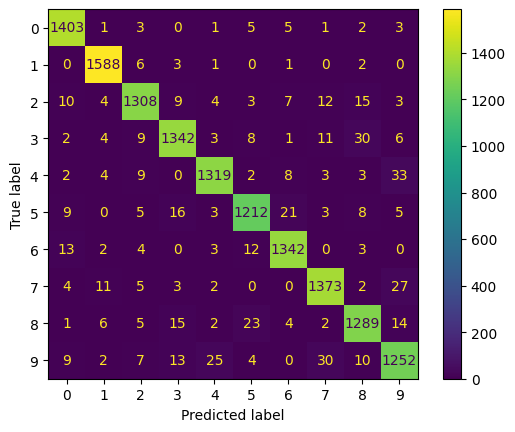

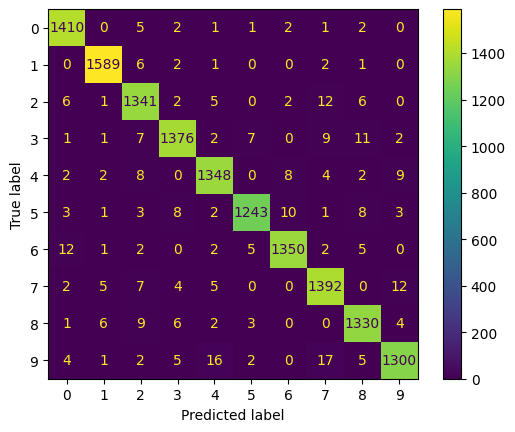

In [134]:
kNN_clf_best = best_models['KNeighborsClassifier_scaled_pca']
rbf_svc_clf_best = best_models['rbf_SVC_scaled_pca']

kNN_clf_best.fit(X_train, y_train)
y_pred_knn = kNN_clf_best.predict(X_val)

rbf_svc_clf_best.fit(X_train, y_train)
y_pred_svc = rbf_svc_clf_best.predict(X_val)

print(f'\n kNN: \t {accuracy_score(y_val, y_pred_knn):.4f}')
print(classification_report(y_val, y_pred_knn))
display_confusion_matrix(y_val, y_pred_knn)

print(f'\n rbf-SCV: \t {accuracy_score(y_val, y_pred_svc):.4f}')
print(classification_report(y_val, y_pred_svc))
display_confusion_matrix(y_val, y_pred_svc)

In [141]:
n_sv = rbf_svc_clf_best.named_steps['classifier'].n_support_.sum()
n_train = len(y_train)
ratio = n_sv / n_train

print(f'Andel support vectorer: {ratio*100:.2f}%')

Andel support vectorer: 18.75%


Här ser jag att båda modellerna har svårt för 9or och blandar ihop dom oftast med 4 och 7 vilket inte är jättekonstigt då de sifforna kan vara lika beroende på hur man skriver dom. 

Båda modellerna klarar 1orna bäst vilket kan var för att det är den mest simpla formen men det kan också bero på vad vi såg i början under våran EDA att det finns något mer 1or i datasetet än övriga siffor. 

Jag hade trott att 5orna skulle prestera något sämre eftersom att under EDAn såg vi att den hade färst antal datapunkter i setet, och ja kanske lite sämre än de andra då den gissar lite på alla andra siffror när det är en 5a men inte egentligen märkbart. Jag reflekterade bara över att det inte fanns någon nolla på gissningarna på 5an i Confusion-Matrisen.

Jag kontrollerar även hur stor andel av support vectorer jag har. 18.75% är bra hade det varit lägre hade modellen varit för simpel och hade den varit högre så hade den varit för anpassad på träningsdatan. 

Överlag så har båda modellerna bra resultat men SVC är något vassare och därför väljer jag att gå vidare med den.

Alltså jag hade ju kunnat gå tillbaka och optimera ännu mer för att få en ännu bättre modell men jag känner mig nöjd här.


 Slutliga rbf-SCV: 	 0.9759
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1343
         1.0       0.99      0.99      0.99      1600
         2.0       0.97      0.97      0.97      1380
         3.0       0.97      0.97      0.97      1433
         4.0       0.97      0.98      0.98      1295
         5.0       0.98      0.97      0.98      1273
         6.0       0.99      0.99      0.99      1396
         7.0       0.97      0.98      0.97      1503
         8.0       0.97      0.96      0.97      1357
         9.0       0.97      0.95      0.96      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000

Andel support vectorer: 16.85%


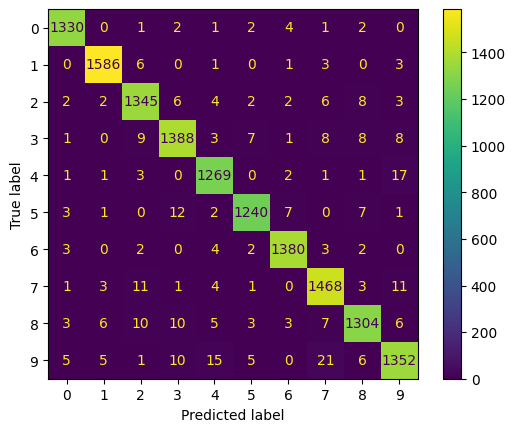

In [144]:
rbf_svc_clf_best.fit(X_train_val, y_train_val)
y_pred = rbf_svc_clf_best.predict(X_test)

n_sv = rbf_svc_clf_best.named_steps['classifier'].n_support_.sum()
n_train = len(y_train_val)
ratio = n_sv / n_train

print(f'\n Slutliga rbf-SCV: \t {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))
display_confusion_matrix(y_test, y_pred)
print(f'Andel support vectorer: {ratio*100:.2f}%')

In [145]:
import joblib

In [146]:
rbf_svc_clf_best.fit(X, y)
joblib.dump(rbf_svc_clf_best, "rbf_svc_clf_best.joblib")

['rbf_svc_clf_best.joblib']